本次实验以AAAI 2014会议论文数据为基础，要求实现或调用无监督聚类算法，了解聚类方法。

# 任务介绍
每年国际上召开的大大小小学术会议不计其数，发表了非常多的论文。在计算机领域的一些大型学术会议上，一次就可以发表涉及各个方向的几百篇论文。按论文的主题、内容进行聚类，有助于人们高效地查找和获得所需要的论文。本案例数据来源于AAAI 2014上发表的约400篇文章，由[UCI](https://archive.ics.uci.edu/ml/datasets/AAAI+2014+Accepted+Papers!)公开提供，提供包括标题、作者、关键词、摘要在内的信息，希望大家能根据这些信息，合理地构造特征向量来表示这些论文，并设计实现或调用聚类算法对论文进行聚类。最后也可以对聚类结果进行观察，看每一类都是什么样的论文，是否有一些主题。

基本要求：
1. 将文本转化为向量，实现或调用无监督聚类算法，对论文聚类，例如10类（可使用已有工具包例如sklearn）；
2. 观察每一类中的论文，调整算法使结果较为合理；
3. 无监督聚类没有标签，效果较难评价，因此没有硬性指标，跑通即可，主要让大家了解和感受聚类算法，比较简单。

扩展要求：
1. 对文本向量进行降维，并将聚类结果可视化成散点图。

注：group和topic也不能完全算是标签，因为
1. 有些文章作者投稿时可能会选择某个group/topic但实际和另外group/topic也相关甚至更相关；
2. 一篇文章可能有多个group和topic，作为标签会出现有的文章同属多个类别，这里暂不考虑这样的聚类；
3. group和topic的取值很多，但聚类常常希望指定聚合成出例如5/10/20类；
4. 感兴趣但同学可以思考利用group和topic信息来量化评价无监督聚类结果，不作要求。

提示：
1. 高维向量的降维旨在去除一些高相关性的特征维度，保留最有用的信息，用更低维的向量表示高维数据，常用的方法有PCA和t-SNE等；
2. 降维与聚类是两件不同的事情，聚类实际上在降维前的高维向量和降维后的低维向量上都可以进行，结果也可能截然不同；
3. 高维向量做聚类，降维可视化后若有同一类的点不在一起，是正常的。在高维空间中它们可能是在一起的，降维后损失了一些信息。

## 参考文献

* *https://scikit-learn.org/stable/modules/feature_extraction.html*
* *https://scikit-learn.org/stable/modules/clustering.html*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 数据集

In [2]:
data_path = './data/AAAI-14-Accepted-Papers.csv'

In [3]:
raw_df = pd.read_csv(data_path)

In [4]:
raw_df.head(3)

,title,authors,groups,keywords,topics,abstract
0,Kernelized Bayesian Transfer Learning,Mehmet Gönen and Adam A. Margolin,Novel Machine Learning Algorithms (NMLA),cross-domain learning\ndomain adaptation\nkern...,APP: Biomedical / Bioinformatics\nNMLA: Bayesi...,Transfer learning considers related but distin...
1,"""Source Free"" Transfer Learning for Text Class...","Zhongqi Lu, Yin Zhu, Sinno Pan, Evan Xiang, Yu...",AI and the Web (AIW)\nNovel Machine Learning A...,Transfer Learning\nAuxiliary Data Retrieval\nT...,AIW: Knowledge acquisition from the web\nAIW: ...,Transfer learning uses relevant auxiliary data...
2,A Generalization of Probabilistic Serial to Ra...,Haris Aziz and Paul Stursberg,Game Theory and Economic Paradigms (GTEP),social choice theory\nvoting\nfair division\ns...,GTEP: Game Theory\nGTEP: Social Choice / Voting,The probabilistic serial (PS) rule is one of t...


In [5]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     398 non-null    object
 1   authors   398 non-null    object
 2   groups    396 non-null    object
 3   keywords  398 non-null    object
 4   topics    394 non-null    object
 5   abstract  398 non-null    object
dtypes: object(6)
memory usage: 18.8+ KB


In [6]:
df = raw_df.copy()

## 数据预处理

In [7]:
df.head(3)

,title,authors,groups,keywords,topics,abstract
0,Kernelized Bayesian Transfer Learning,Mehmet Gönen and Adam A. Margolin,Novel Machine Learning Algorithms (NMLA),cross-domain learning\ndomain adaptation\nkern...,APP: Biomedical / Bioinformatics\nNMLA: Bayesi...,Transfer learning considers related but distin...
1,"""Source Free"" Transfer Learning for Text Class...","Zhongqi Lu, Yin Zhu, Sinno Pan, Evan Xiang, Yu...",AI and the Web (AIW)\nNovel Machine Learning A...,Transfer Learning\nAuxiliary Data Retrieval\nT...,AIW: Knowledge acquisition from the web\nAIW: ...,Transfer learning uses relevant auxiliary data...
2,A Generalization of Probabilistic Serial to Ra...,Haris Aziz and Paul Stursberg,Game Theory and Economic Paradigms (GTEP),social choice theory\nvoting\nfair division\ns...,GTEP: Game Theory\nGTEP: Social Choice / Voting,The probabilistic serial (PS) rule is one of t...


In [8]:
df = df.fillna('')

## 特征工程

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [10]:
max_feat_num = 10000

vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(2, 2), max_features=max_feat_num)
X = vectorizer.fit_transform(df['abstract'])

In [11]:
X.shape

(398, 10000)

## 模型

In [12]:
from sklearn.cluster import KMeans

In [13]:
n_clusters = 10
n_epoch = 10000

model = KMeans(n_clusters=n_clusters, max_iter=n_epoch, random_state=42)

In [14]:
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10000,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [15]:
df['label'] = model.labels_

In [16]:
df[df.label==0][['title']]

,title
11,R2: An Efficient MCMC Sampler for Probabilisti...
47,Active Learning with Model Selection via Neste...
61,Using The Matrix Ridge Approximation to Speedu...
64,Fast and Accurate Influence Maximization on La...
71,Fast consistency checking of very large real-w...
104,Lifting Relational MAP-LP Relaxations using Pe...
111,Linear-Time Filtering Algorithms for the Disju...
114,Give a Hard Problem to a Diverse Team: Explori...
130,Wormhole Hamiltonian Monte Carlo
179,Explanation-Based Approximate Weighted Model C...


In [17]:
df[df.label==1][['title']]

,title
0,Kernelized Bayesian Transfer Learning
19,Semantic Graph Construction for Weakly-Supervi...
25,Towards Understanding Unscripted Gesture and L...
32,Exact Subspace Clustering in Linear Time
35,PREGO: An Action Language for Belief-Based Cog...
50,Predicting Emotions in User-Generated Videos
72,Encoding Tree Sparsity in Multi-Task Learning:...
78,Grounding Acoustic Echoes In Single View Geome...
81,Extracting Keyphrases from Research Papers usi...
86,Multi-Instance Learning with Distribution Change


## 模型可视化

cluster分布

<AxesSubplot:>

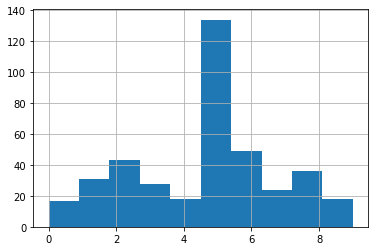

In [18]:
df.label.hist()

### PCA

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)

In [20]:
virtual_X = pca.fit_transform(X.toarray())

In [21]:
virtual_df = pd.DataFrame({
    'x1': virtual_X[:,0],
    'x2': virtual_X[:, 1],
    'label': model.labels_,
})

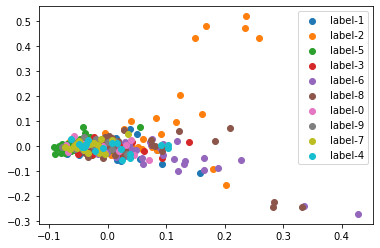

In [22]:
for label in virtual_df.label.unique():
    x1 = virtual_df[virtual_df.label==label].x1
    x2 = virtual_df[virtual_df.label==label].x2
    plt.scatter(x1, x2, label='label-'+str(label))
    
plt.legend()